# FU Ori Sub Interface (V1057 Cyg)

### Caltech Summer 2019

Another draft at doing everything with stellar atmospheres and line broadening. Pulling functions from a external .py files. 
This notebook should contain few function calls and should operate on a fairly automated basis, but another layer will still be added.

Started 5 August 2019. 

### Imports 

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from scipy import signal
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_new import *
from fu_ori_classes_new import *
import matplotlib.gridspec as gridspec

### Constants (astronomy is in cgs, right?)

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16
sec_YEAR = 365*24*60*60

In [3]:
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

## Making an instance of the class FU Ori and testing

In [4]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_spec, wave_upper_spec, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_spec = wave_lower_spec
        self.wave_upper_spec = wave_upper_spec
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = []
        self.rot_star = 0
        
        print('Created environment.')
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, a_v, dist, grav, direc):
        print('Creating FU Ori object...')
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v)
        print('Creating disk annuli...')
        fuori.setAnnuliValues(10000, 2000, 200, 1*r_star)
        print('Reading stellar atmosphere directory...')
        fuori.createAnnuliFromDirec(grav, direc, model='stellar atmospheres')
        print('Preparing annuli for broadening and summing...')
        fuori.prepareAnnuli(self.wave_lower_spec,self.wave_upper_spec, \
                            binning=1, broaden=True, interp_type='linear')
        print('Creating model spectrum...')
        fuori.createModelSpectrum('stellar atmospheres', broaden=True)
        print('FU Ori object created.')
        self.fuori.append(fuori)
    
    # Creating rotating star
    def createRotStar(self, temp, r_star, m_star, inc, a_v, dist, grav, direc):
        self.rot_star = Star(temp, grav, m_star, r_star, direc, np.radians(inc), a_v) 
        self.rot_star.setSpectrumFromDirec('stellar atmospheres', temp, grav)
        self.rot_star.prepareSpectrum(self.wave_lower_spec, self.wave_upper_spec, 1, 'linear')
        self.rot_star.broadenStellarSpectrum()
    
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, obj_type, obj_num, broaden, redden):
        if obj_type == 'fu ori':
            return self.fuori[obj_num].viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        elif obj_type == 'rotating star':
            return self.rot_star.getLuminosity(wave_lower, wave_upper, broaden, redden)
    
    # For viewing model SED
    def viewModelSED(self, wave_lower, wave_upper, broaden):
        waves, lums = self.fuori.viewModelSpectrum(wave_lower, wave_upper, broaden, redden)
        return np.log10(waves*1e-4), np.log10(np.cos(np.radians(self.inc))*waves*1e-8*lums/(2*np.pi*(self.dist**2)))

    # Useful modules
    def viewFracLums(self, wave_lower, wave_upper, obj_num, data_type, x_axis_type):
        return self.fuori[obj_num].calculateFracLums(wave_lower, wave_upper, data_type, x_axis_type)
        
        
#         if x_axis_type == 'distance':
#             return r_avg/obj.r_star, (frac_lums/total_lum)*(inner_disk_diff/temps_diff)
#         if x_axis_type == 'temperature':
#             return temps, (frac_lums/total_lum)*(inner_disk_diff/temps_diff)
    
    
    def viewGravComparison(self, obj_nums, wave_lower, wave_upper, broaden, redden):
        obj_n1, obj_n2 = obj_nums
        wav, lum1 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n1, broaden, redden)
        wav, lum2 = self.viewModelSpectrum(wave_lower, wave_upper, 'fu ori', obj_n2, broaden, redden)
        lum_diff = np.abs(lum2 - lum1)
        return wav, lum_diff    

In [7]:
gaia17bpi_env = FUOriEnvironment(3.9e3, 25e3, 0, 0)
gaia17bpi_env.createFUOri(r_star = 1.43*R_SUN, r_outer = 200*R_SUN, m_star = (10**0)*M_SUN,\
                          m_dot = (10**0.56) * 1e-6 * M_SUN / 3.154e7, inc = 15, \
                          a_v = 3.8, dist  = 550*3.08567758128e18, \
                          grav = 4.0, direc = DIREC)
gaia17bpi_env.createFUOri(r_star = 1.69*R_SUN, r_outer = 200*R_SUN, m_star = (10**-0.06)*M_SUN,\
                          m_dot = (10**0.82) * 1e-6 * M_SUN / 3.154e7, inc = 45, \
                          a_v = 3.8, dist  = 550*3.08567758128e18, \
                          grav = 4.0, direc = DIREC)
gaia17bpi_env.createFUOri(r_star = 2.68*R_SUN, r_outer = 200*R_SUN, m_star = (10**-0.1)*M_SUN,\
                          m_dot = (10**1.5) * 1e-6 * M_SUN / 3.154e7, inc = 75, \
                          a_v = 3.8, dist  = 550*3.08567758128e18, \
                          grav = 4.0, direc = DIREC)

Created environment.
Creating FU Ori object...
Creating disk annuli...
Reading stellar atmosphere directory...
Used stellar atmosphere at T = 7800. with log g = 4.0
Used stellar atmosphere at T = 7600. with log g = 4.0
Used stellar atmosphere at T = 7400. with log g = 4.0
Used stellar atmosphere at T = 7200. with log g = 4.0
Used stellar atmosphere at T = 7000. with log g = 4.0
Used stellar atmosphere at T = 6800. with log g = 4.0
Used stellar atmosphere at T = 6600. with log g = 4.0
Used stellar atmosphere at T = 6400. with log g = 4.0
Used stellar atmosphere at T = 6200. with log g = 4.0
Used stellar atmosphere at T = 6000. with log g = 4.0
Used stellar atmosphere at T = 5800. with log g = 4.0
Used stellar atmosphere at T = 5600. with log g = 4.0
Used stellar atmosphere at T = 5400. with log g = 4.0
Used stellar atmosphere at T = 5200. with log g = 4.0
Used stellar atmosphere at T = 5000. with log g = 4.0
Used stellar atmosphere at T = 4800. with log g = 4.0
Used stellar atmosphere a

KeyboardInterrupt: 

# V1057 Cyg Data

In [10]:
PATH = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Data/V1057 Cyg/'
DIST = 550*3.08567758128e18

def getDataArray(data_file):
    txt = open(data_file)
    fulltxt = txt.readlines()
    # Cleaning lines
    newtxt = []
    for i in range(len(fulltxt)):
        line = fulltxt[i][:-1]
        line = line.split()
        if line[0] == '#':
            line = [line[1], line[2]]
        newtxt.append(line)
    # Casting as floats
    newtxt = np.array(newtxt).astype(np.float64)
    return newtxt

In [11]:
newtxt = getDataArray(PATH + 'blue0116_flux.spec.txt')

waves_pal = newtxt[:,0] 
fluxes_pal = newtxt[:,1]

newtxt2 = getDataArray(PATH + 'red0116_flux.spec.txt')

waves_pal2 = newtxt2[:,0][10:]
fluxes_pal2 = newtxt2[:,1][10:]

### Infrared Data

In [12]:
REGIONS = np.array([(1e3, 11.8e3), (13e3, 15.4e3), (17e3, 20.5e3), (23e3, 30e3)])

In [13]:
def cleanPoints(waves, lums, regions):
    waves_final, lums_final = [], []
    exclude = []
    for i in range(len(regions)):
        start, end = regions[i]
        ind_lower = np.searchsorted(waves, int(start))
        ind_upper = np.searchsorted(waves, end)
        bad_points = np.arange(ind_lower, ind_upper+1, 1)
        for i in range(len(bad_points)):
            exclude.append(bad_points[i])

    waves_final = np.delete(waves, exclude)
    lums_final = np.delete(lums, exclude)
    return waves_final, lums_final

In [14]:
newtxt3 = getDataArray(PATH + 'jband_V1057Cyg.txt')

waves_INF = newtxt3[:,0] *1e4
fluxes_INF = newtxt3[:,1]

newtxt4 = getDataArray(PATH + 'hband_V1057Cyg.txt')

waves_INF2 = newtxt4[:,0][10:] * 1e4
fluxes_INF2 = newtxt4[:,1][10:]

newtxt5 = getDataArray(PATH + 'kband_V1057Cyg.txt')

waves_INF3 = newtxt5[:,0][10:] * 1e4
fluxes_INF3 = newtxt5[:,1][10:]

waves_INF, fluxes_INF = cleanPoints(waves_INF, fluxes_INF, REGIONS)
waves_INF2, fluxes_INF2 = cleanPoints(waves_INF2, fluxes_INF2, REGIONS)
waves_INF3, fluxes_INF3 = cleanPoints(waves_INF3, fluxes_INF3, REGIONS)

C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  if sys.path[0] == '':
C:\Users\tonyc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  del sys.path[0]


## Plotting Full FU Ori Model with Data

Recall:
$$F = \dfrac{L^\text{TOT}\cos i}{2\pi d^2}$$

In [15]:
gaia17bpi_env.fuori

In [29]:
START = 4000
END = 5000
wav, lum = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 0, True, True)
wav2, lum2 = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 1, True, True)
wav3, lum3 = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 2, True, True)
# wav4, lum4 = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 3, True, True)

### Optional smoothing

In [30]:
from astropy.convolution import Gaussian1DKernel, convolve
x1 = wav[::4]
y1 = lum[::4]*np.cos(np.radians(60))/(2*np.pi*DIST**2)

# Create kernel
g1 = Gaussian1DKernel(stddev=0.2)

# Convolve data
z1 = convolve(y1, g1)

In [31]:
gaia17bpi_env.fuori[0].annuli[0].temp,\
gaia17bpi_env.fuori[0].getTotalLum()/L_SUN


(7800.0, 39.78248377203714)

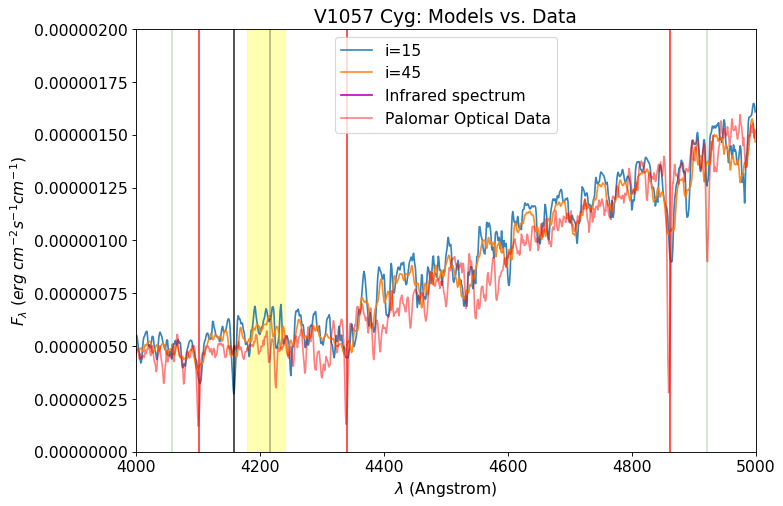

In [36]:
fig=plt.figure(figsize=(10, 7), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.title('V1057 Cyg: Models vs. Data')
plt.plot(wav, lum*np.cos(np.radians(15))/(2*np.pi*DIST**2), alpha=0.9,label='i=15')
# plt.plot(x1, z1, label='Smoothed model')
plt.plot(wav2, lum2*np.cos(np.radians(45))/(2*np.pi*DIST**2), alpha=0.9,label='i=45')
# plt.plot(wav3, lum3*np.cos(np.radians(75))/(2*np.pi*DIST**2), alpha=0.9,label='i=75')
# plt.plot(wav4, lum4*np.cos(np.radians(60))/(2*np.pi*DIST**2), alpha=0.9,label='Different')

# plt.plot(wav5,2*lum5*np.cos(np.radians(60))/(2*np.pi*DIST**2), alpha=0.6,label=' Low temp, higher i')




plt.plot(waves_INF3, fluxes_INF3*1e8, 'm-', label='Infrared spectrum')
plt.plot(waves_pal, fluxes_pal*1e8, 'r-', alpha=0.5,label='Palomar Optical Data')


# plt.plot(x1, z1, 'r-', label='Palomar Data (Smoothed)')

plt.axvline(4059, color='g', alpha=0.2)
plt.axvline(4158, color='k', alpha=0.8)
plt.axvline(4922, color='g', alpha=0.2)
plt.axvline(4216, color='k', alpha=0.3)

plt.axvline(4341, color='r', alpha=0.8)
plt.axvline(4861, color='r', alpha=0.8)
plt.axvline(4102, color='r', alpha=0.8)
plt.axvline(6563, color='r', alpha=0.8)
plt.axvspan(4180, 4240, alpha=0.3, color='yellow')

plt.axvline(21638, color='r', alpha=0.8)




plt.axvline(6300, color='g', alpha=0.2)




plt.xlabel(r'$\lambda$ (Angstrom)')
plt.ylabel(r'$F_\lambda\; (erg \;cm^{-2} s^{-1} cm^{-1})$')
plt.xlim(START, END)
plt.legend()
plt.ylim(0,20e-7)
save_string = str(START) + '_' + str(END) + '.png'
# plt.savefig(save_string, dpi = 120)
plt.show()

## With Residual Plot

In [48]:
def compareModeltoData(wave_model, flux_model, wave_data, flux_data):
    dat_func = interpolate.interp1d(wave_data, flux_data, kind='linear')
    flux_data_interp = dat_func(wave_model)
    avg_diff = np.mean(flux_model - flux_data_interp)
    flux_model_scaled = flux_model - avg_diff
    flux_percent = (flux_model_scaled - flux_data_interp)*100/flux_data_interp
    correlation = signal.correlate(flux_model_scaled, flux_data_interp, 'valid')
    return flux_model_scaled, flux_percent, correlation

In [49]:
wav, flux = wav, lum*np.cos(np.radians(15))/(2*np.pi*DIST**2)
wav2, flux2 = wav2, lum2*np.cos(np.radians(45))/(2*np.pi*DIST**2)
wav3, flux3 = wav3, lum3*np.cos(np.radians(75))/(2*np.pi*DIST**2)

flux_model_scaled, flux_percent, correlation = compareModeltoData(wav, flux, waves_INF3, fluxes_INF3*1e8)
flux_model_scaled2, flux_percent2, correlation2 = compareModeltoData(wav2, flux2, waves_INF3, fluxes_INF3*1e8)
flux_model_scaled3, flux_percent3, correlation3 = compareModeltoData(wav3, flux3, waves_INF3, fluxes_INF3*1e8)

NameError: name 'wav3' is not defined

In [50]:
correlation, correlation2, correlation3

NameError: name 'correlation' is not defined

NameError: name 'flux_model_scaled' is not defined

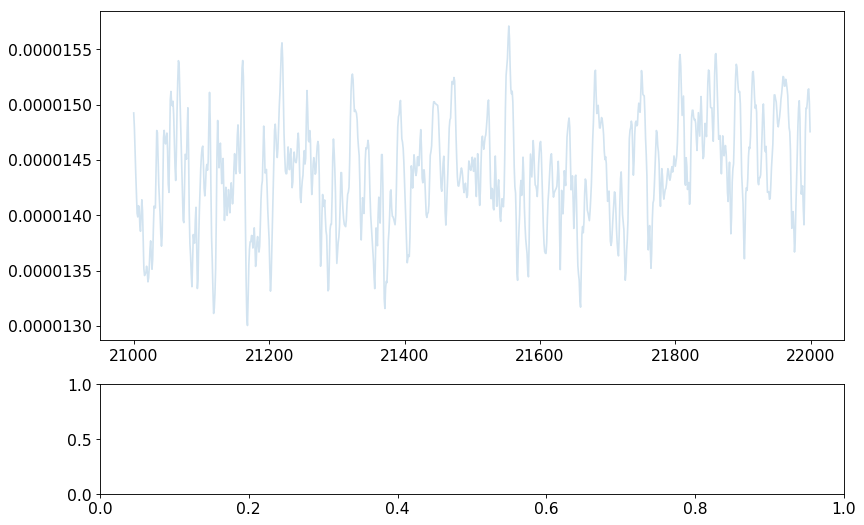

In [51]:
fig=plt.figure(figsize=(12, 8), dpi= 80)
gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1])

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax.plot(wav, flux, alpha=0.2,label='Model')
ax.plot(wav, flux_model_scaled, alpha=0.5,label=r'Model - $\Delta\; F_\lambda$')
ax.plot(wav2, flux_model_scaled2, alpha=0.5,label=r'Model - $\Delta\; F_\lambda$')


ax.axvline(4341, color='r', alpha=0.8)
ax.axvline(4861, color='r', alpha=0.8)
ax.axvline(4102, color='r', alpha=0.8)

ax.axvspan(4180, 4240, alpha=0.3, color='yellow')
ax.axvline(4438, color='g', alpha=0.8)

ax.plot(waves_INF3, fluxes_INF3*1e8, 'm-',label='Data')
# ax.set_ylim(0, 2e-6)

ax.legend()

ax2.plot(wav, np.zeros(len(wav)), 'k-')
ax2.plot(wav, flux_percent, 'r-', label=r'% deviation from avg. $\Delta\; F_\lambda$')

ax2.axvline(4341, color='r', alpha=0.8)
ax2.axvline(4861, color='r', alpha=0.8)
ax2.axvline(4102, color='r', alpha=0.8)

ax2.legend()
plt.suptitle('HBC 722: Model vs. Data')
fig.text(0.5, 0.04, r'$\lambda$ (Angstrom)', ha='center')
fig.text(0.01, 0.5, r'$F_\lambda\; (erg \;cm^{-2} s^{-1} cm^{-1})$', va='center', rotation='vertical')
ax.set_xlim(START, END)
ax2.set_xlim(START, END)
ax2.set_ylim(-50, 50)

plt.show()
# fig.savefig("Surface Gravity Comparison/comparison.png", dpi=140)

## Velocity Offset

In [52]:
CENTRAL = 4922

In [53]:
def tick_function(wave, central):
    v = (wave - central)*c_LIGHT*1e-5/central
    return ["%.0f" % int(z) for z in v]

NameError: name 'flux_model_scaled' is not defined

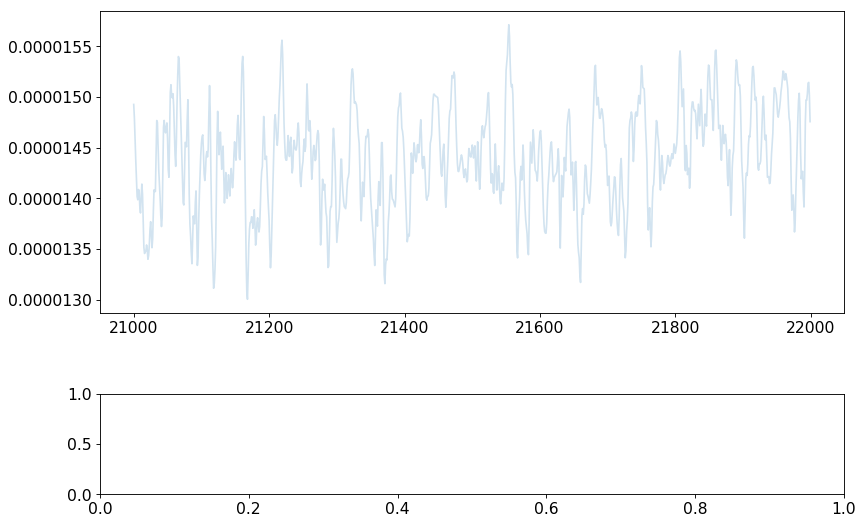

In [54]:
fig=plt.figure(figsize=(12, 8), dpi= 80)
gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1])
plt.subplots_adjust(hspace=0.4)

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax.plot(wav, flux, alpha=0.2,label='Model')
ax.plot(wav, flux_model_scaled, 'orange',alpha=0.5,label=r'Model - $\Delta\; F_\lambda$')

ax.axvline(CENTRAL, color='g', alpha=0.8)

ax.plot(waves_pal, fluxes_pal*1e8, 'm-',label='Data')
ax.set_xlabel('Wavelength (Angstrom)')

ax.legend()

ax2.plot(waves_pal, fluxes_pal*1e8, 'm-',label='Data')
ax2.plot(wav, flux_model_scaled, 'orange',alpha=0.5,label=r'Model - $\Delta\; F_\lambda$')
ax2.axvline(CENTRAL, color='g', alpha=0.8)

ax.set_ylim(0, 2e-6)

ax3 = ax2.twiny()

plt.suptitle('HBC 722: Model vs. Data')
fig.text(0.01, 0.5, r'$F_\lambda\; (erg \;cm^{-2} s^{-1} cm^{-1})$', va='center', rotation='vertical')
ax.set_xlim(START, END)

START_2 = 4900
END_2 = 5000

ax2.set_xlim(START_2, END_2)
ax3.set_xlim(START_2, END_2)
ax2.set_ylim(8e-7,17e-7 )
new_tick_locations = np.array([CENTRAL-2, CENTRAL+2])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, CENTRAL))
ax2.tick_params(axis='x', rotation=70)
ax2.set_xlabel('Observed velocity (km/s)')

plt.show()
# fig.savefig("Surface Gravity Comparison/comparison.png", dpi=140)

## Fractional Fluxes

In [89]:
temp, frac_lums = gaia17bpi_env.viewFracLums(4e3, 5e3, 0, 'broadened', 'temperature')
temp2, frac_lums2 = gaia17bpi_env.viewFracLums(5e3, 6e3, 0, 'broadened', 'temperature')
temp3, frac_lums3 = gaia17bpi_env.viewFracLums(6e3, 7e3, 0, 'broadened', 'temperature')
temp4, frac_lums4 = gaia17bpi_env.viewFracLums(20e3, 21e3, 0, 'broadened', 'temperature')
temp5, frac_lums5 = gaia17bpi_env.viewFracLums(22e3, 23e3, 0, 'broadened', 'temperature')

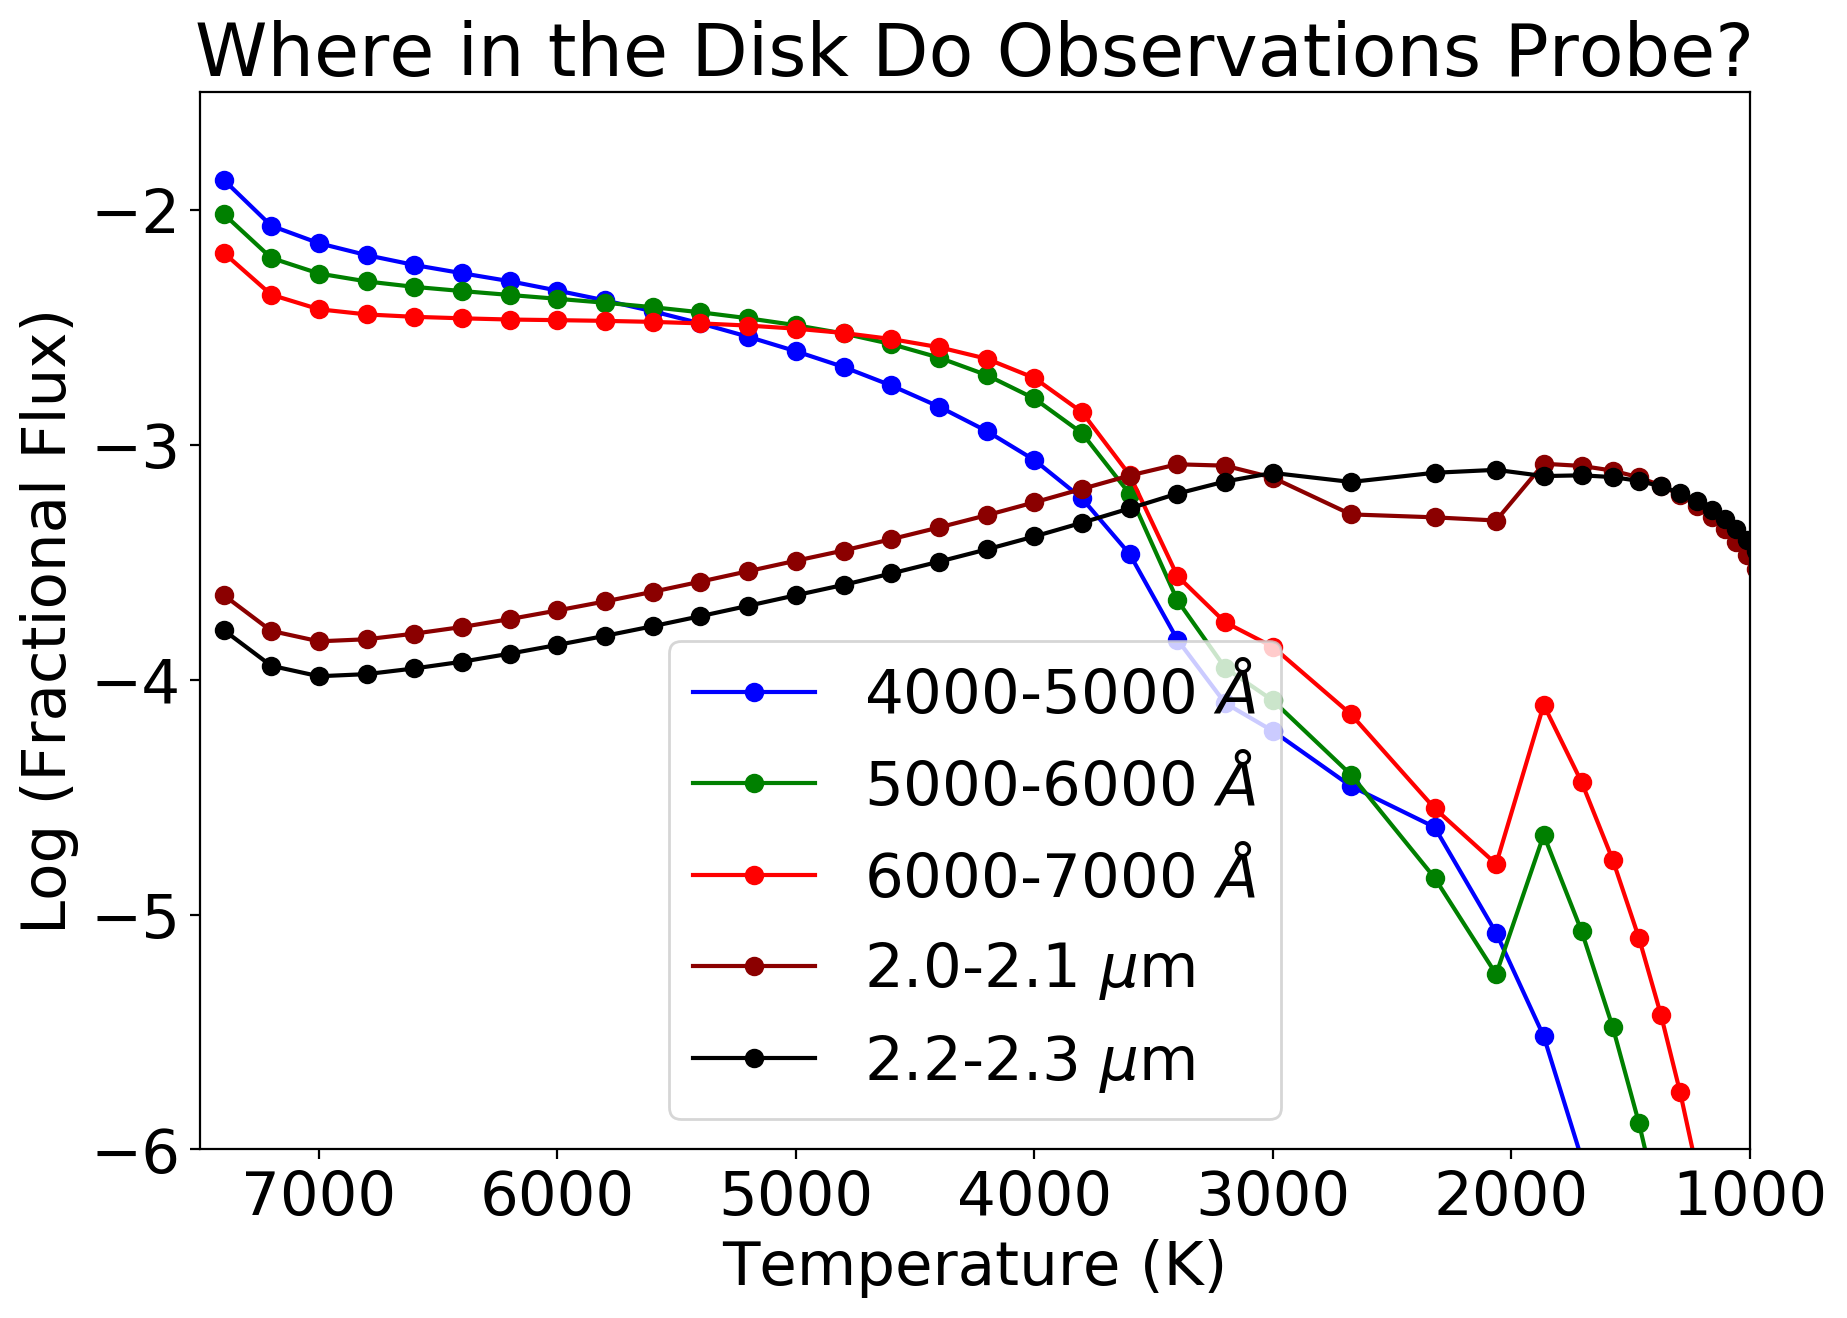

In [90]:
fig=plt.figure(figsize=(10, 7), dpi= 200)
plt.rcParams.update({'font.size': 22})
plt.title('Where in the Disk Do Observations Probe?')
plt.ylabel('Log (Fractional Flux)')
plt.xlabel('Temperature (K)')
plt.plot(temp, np.log10(frac_lums), 'bo-', label=r'4000-5000 $\AA$')
plt.plot(temp2, np.log10(frac_lums2), 'go-', label=r'5000-6000 $\AA$')
plt.plot(temp3, np.log10(frac_lums3), 'ro-', label=r'6000-7000 $\AA$')
plt.plot(temp4, np.log10(frac_lums4), 'o-',color='darkred', label=r'2.0-2.1 $\mu$m')
plt.plot(temp5, np.log10(frac_lums5), 'ko-', label=r'2.2-2.3 $\mu$m')


plt.xlim(gaia17bpi_env.fuori[0].annuli[0].temp+100, 1000)
plt.ylim(-6, -1.5)
plt.legend()
# plt.savefig('frac_flux.png', dpi=200)
plt.show()

In [125]:
temp, frac_lums = gaia17bpi_env.viewFracLums(4e3, 5e3, 0, 'broadened', 'distance')
temp2, frac_lums2 = gaia17bpi_env.viewFracLums(7e3, 8e3, 0, 'broadened', 'distance')
temp3, frac_lums3 = gaia17bpi_env.viewFracLums(22e3, 23e3, 0, 'broadened', 'distance')


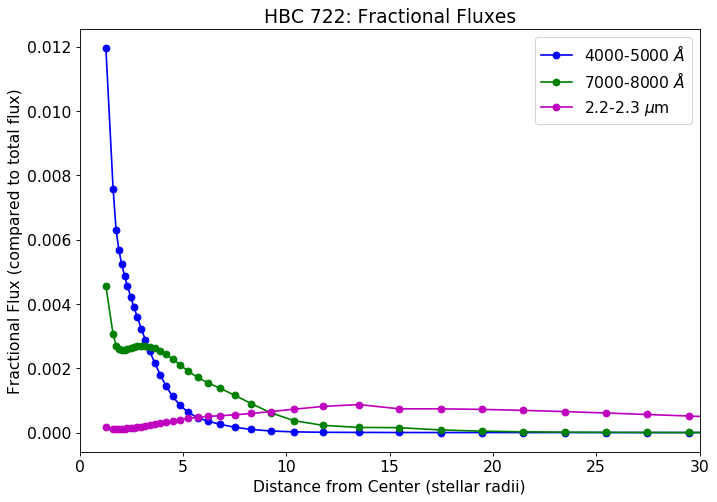

In [126]:
fig=plt.figure(figsize=(10, 7), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.title('HBC 722: Fractional Fluxes')
plt.ylabel('Fractional Flux (compared to total flux)')
plt.xlabel('Distance from Center (stellar radii)')
plt.plot(temp, frac_lums, 'bo-', label=r'4000-5000 $\AA$')
plt.plot(temp2, frac_lums2, 'go-', label=r'7000-8000 $\AA$')
plt.plot(temp3, frac_lums3, 'mo-', label=r'2.2-2.3 $\mu$m')


plt.xlim(0, 30)
# plt.ylim(0, 0.001)
plt.legend()
plt.show()

## Broadening velocity

In [71]:
def viewObsVel(obj_num):
    obj = gaia17bpi_env.fuori[obj_num]
    r_avg = np.zeros(len(obj.annuli))
    vel = np.zeros(len(obj.annuli))
    for i in range(len(obj.annuli)):
        annulus = obj.annuli[i]
        r_avg[i] = (annulus.r_inner + annulus.r_outer)/2
        vel[i]= getObservedVelocity(obj.m_star, r_avg[i], obj.inc)
    print(np.degrees(obj.inc))
    return r_avg/obj.r_star, vel*1e-5 
def viewObsVelMOD(obj_num):
    obj = gaia17bpi_env.fuori[obj_num]
    r_avg = np.zeros(len(obj.annuli))
    for i in range(len(obj.annuli)):
        annulus = obj.annuli[i]
        r_avg[i] = (annulus.r_inner + annulus.r_outer)/2
    vel= getObservedVelocity(0.5*obj.m_star, r_avg, obj.inc)
    print(obj.inc)
    return r_avg/obj.r_star, vel*1e-5 



In [72]:
gaia17bpi_env.fuori[0].annuli[0].r_inner/R_SUN, \
gaia17bpi_env.fuori[0].annuli[0].r_outer/R_SUN,\
gaia17bpi_env.fuori[0].m_star/M_SUN

(1.43, 2.1573125541874427, 1.0)

In [73]:
rad, vel = viewObsVel(0)


14.999999999999998


In [74]:
np.degrees(0.96)

55.00394833255903

In [75]:
getObservedVelocity(0.4*M_SUN, 12*R_SUN, np.radians(50))*1e-5

61.08892428800383

In [76]:
G, M_SUN, R_SUN/1e10

(6.67259e-08, 1.99e+33, 6.96)

In [77]:
((G*M_SUN/(R_SUN))**(1/2))*1e-5

436.7864312158208

In [78]:
((50*1e5)**2/G) * R_SUN / M_SUN * 3

0.03931180512948415

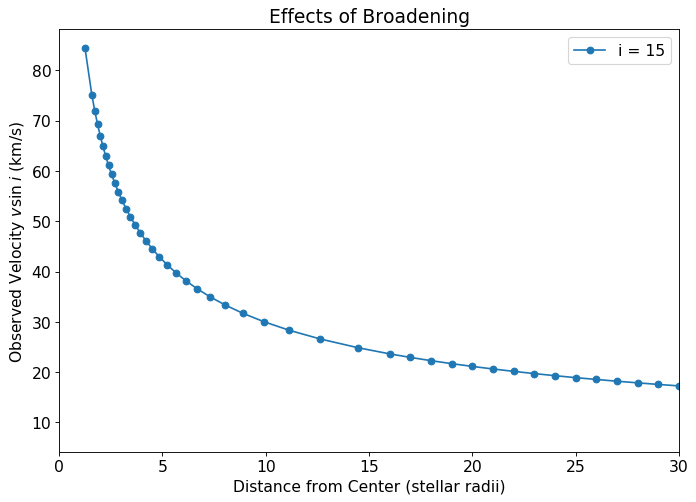

In [79]:
fig=plt.figure(figsize=(10, 7), dpi= 80)
plt.rcParams.update({'font.size': 14})
plt.title('Effects of Broadening')
plt.ylabel(r'Observed Velocity $v\sin \;i$ (km/s) ')
plt.xlabel('Distance from Center (stellar radii)')
plt.plot(rad, vel, 'o-', label='i = 15')
# plt.plot(radMOD, velMOD, 'o-', label='i = 15, modified mass')

# plt.plot(rad2, vel2, 'o-', label='i = 35')



plt.xlim(0, 30)
# plt.ylim(0, 0.001)
plt.legend()
plt.show()

## Comparing different surface gravities

In [51]:

wav, lum = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 0, False, True)
wav2, lum2 = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 1, False, True)

wav0 = wav
lum0 = (lum - lum2)
diff_avg = np.mean(lum0)
lum_percent = (lum0 - diff_avg)/diff_avg

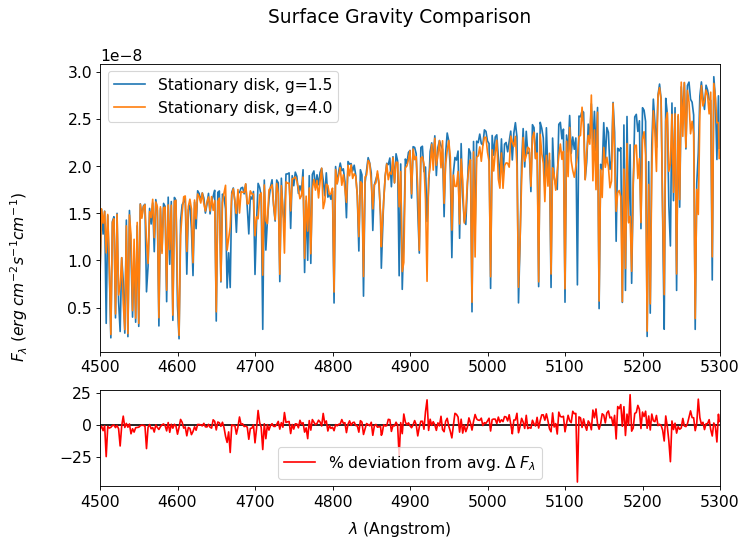

In [53]:
fig=plt.figure(figsize=(10, 7), dpi= 80)
gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1])

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax.plot(wav, lum*np.cos(np.radians(10))/(2*np.pi*DIST**2), label='Stationary disk, g=1.5')
ax.plot(wav2, lum2*np.cos(np.radians(10))/(2*np.pi*DIST**2), label='Stationary disk, g=4.0')
# ax.plot(waves_DAT, fluxes_DAT*1e8, 'r--', label='Infrared spectrum')

ax.legend()

ax2.plot(wav0, np.zeros(len(wav0)), 'k-')
ax2.plot(wav0, lum_percent, 'r-', label=r'% deviation from avg. $\Delta\; F_\lambda$')



ax2.legend()
plt.suptitle('Surface Gravity Comparison')
fig.text(0.5, 0.04, r'$\lambda$ (Angstrom)', ha='center')
fig.text(0.01, 0.5, r'$F_\lambda\; (erg \;cm^{-2} s^{-1} cm^{-1})$', va='center', rotation='vertical')
ax.set_xlim(START, END)
ax2.set_xlim(START, END)

plt.show()
# fig.savefig("Surface Gravity Comparison/comparison.png", dpi=140)

In [54]:
waves_print = []

for i in range(4000, 25000, 500):
    waves_print.append((i, i+500))

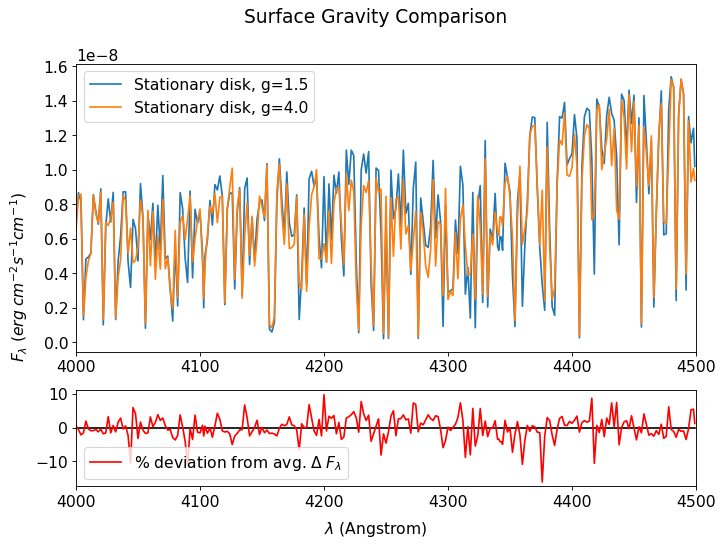

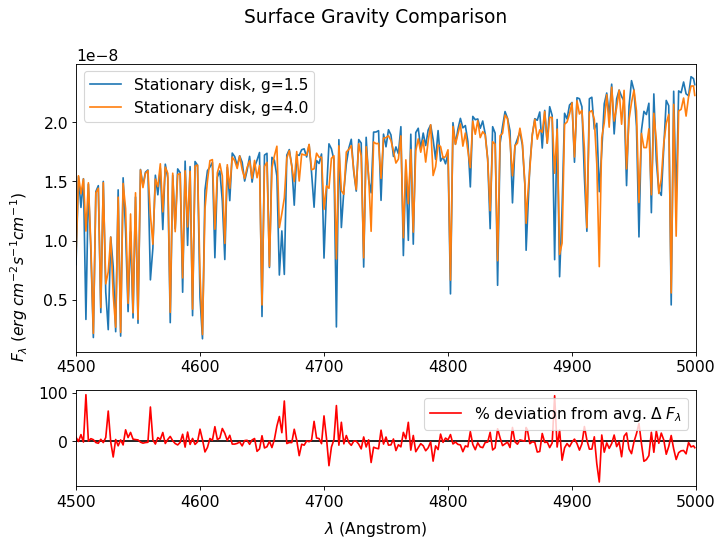

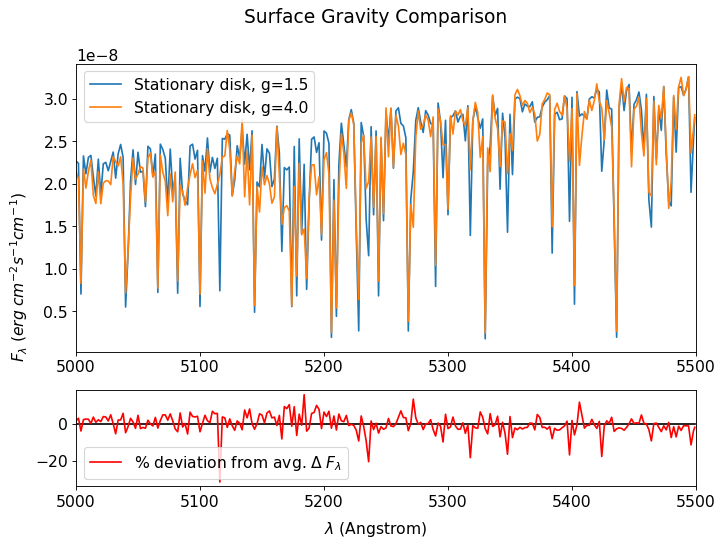

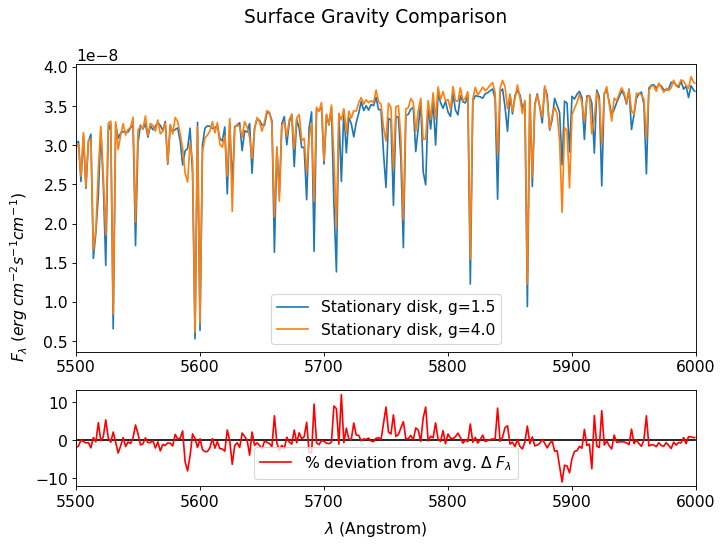

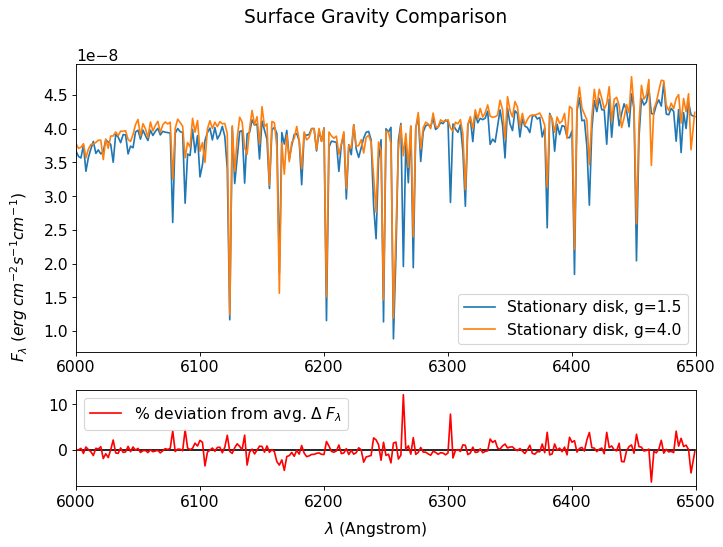

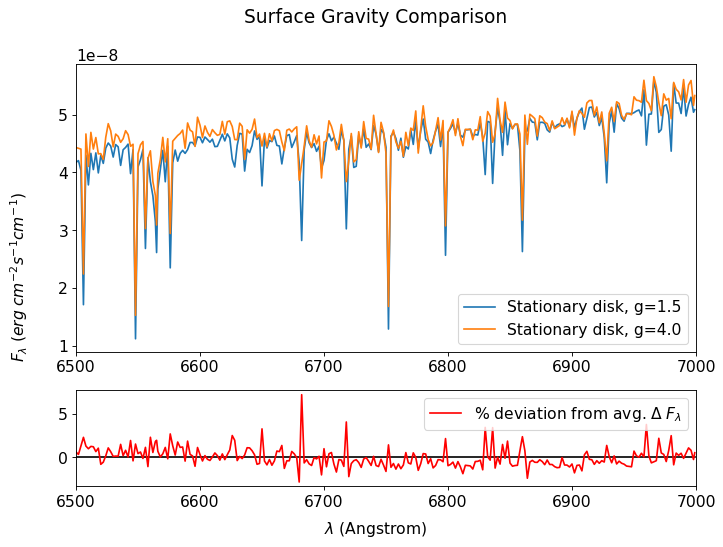

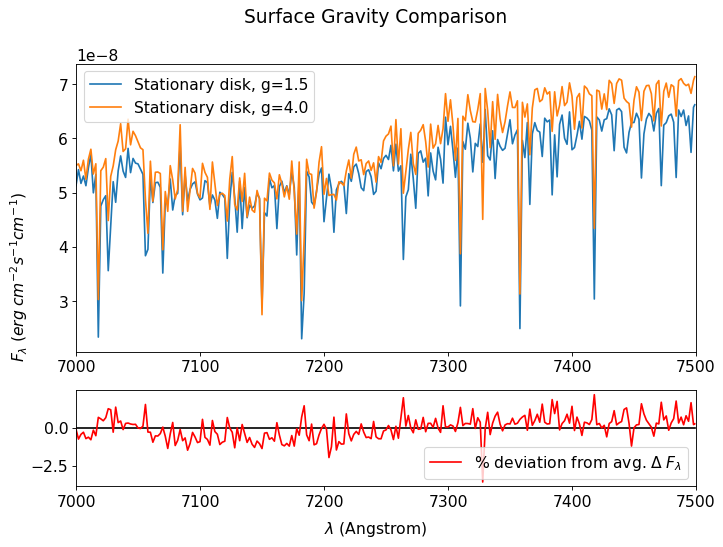

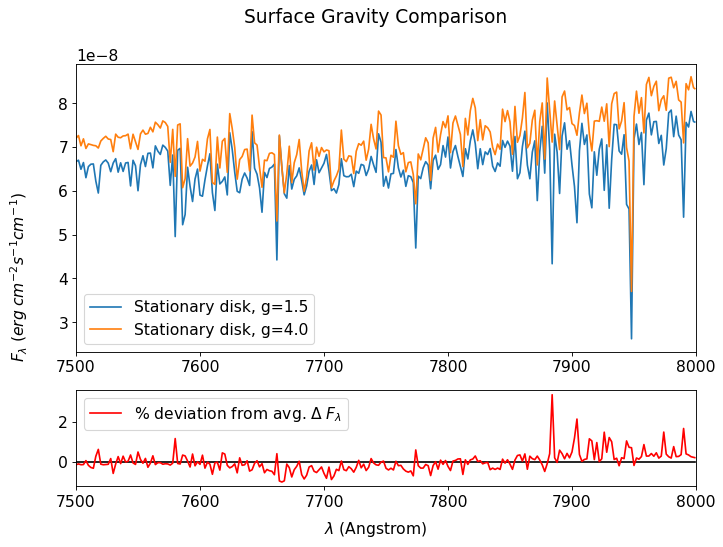

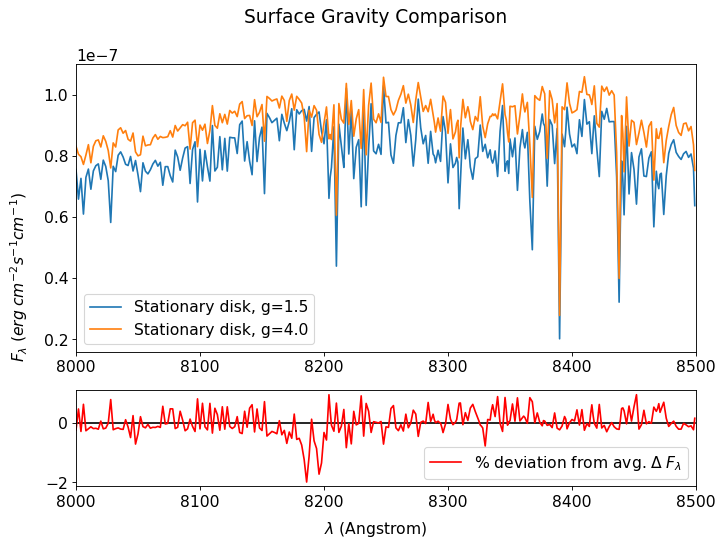

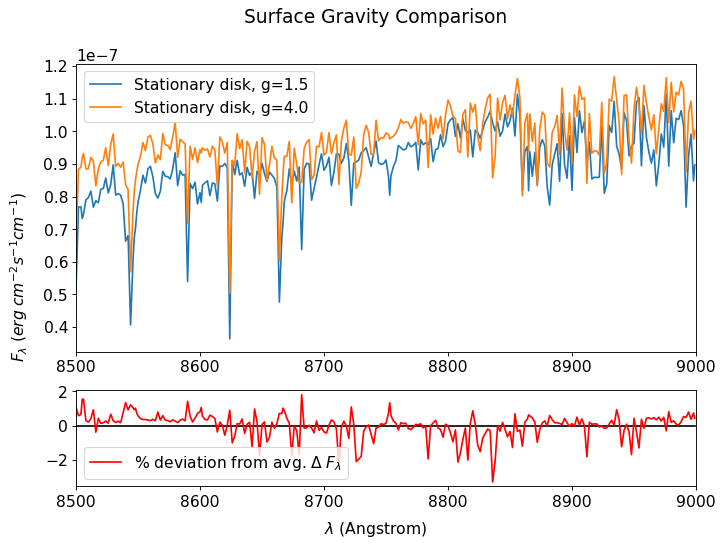

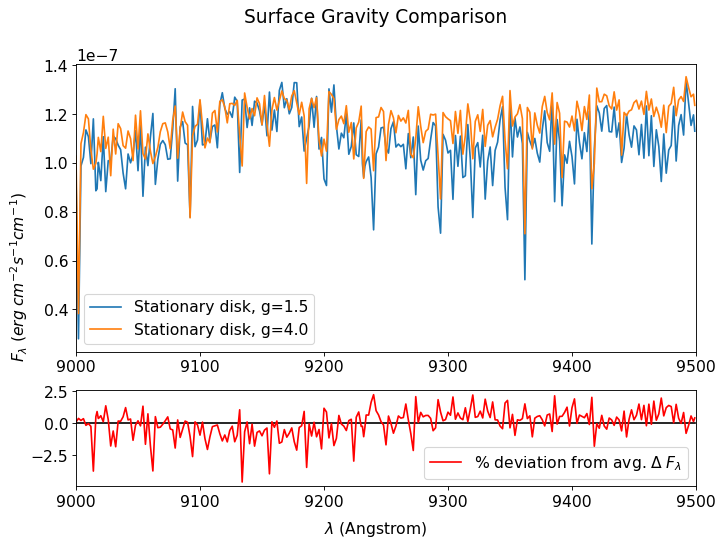

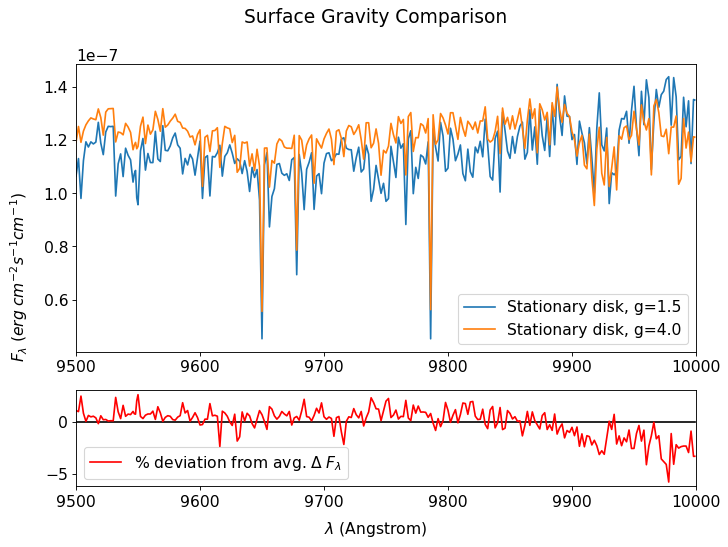

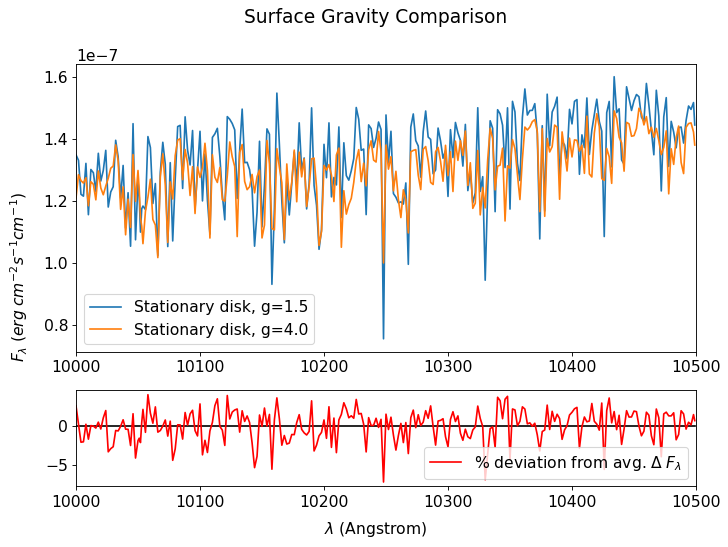

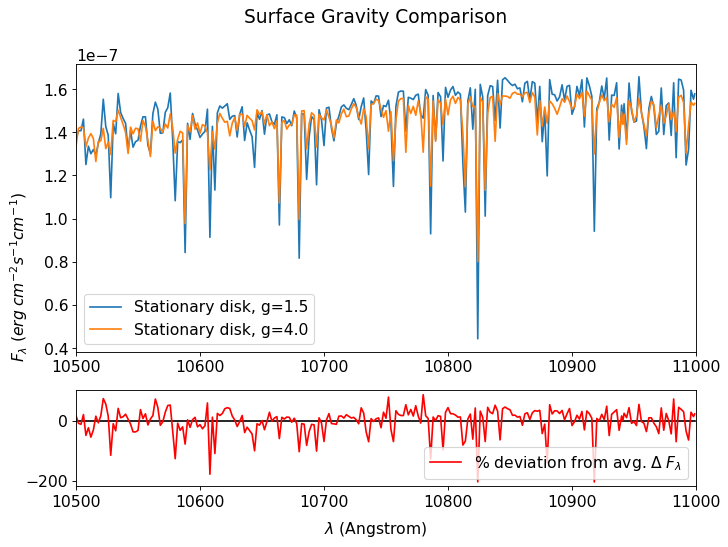

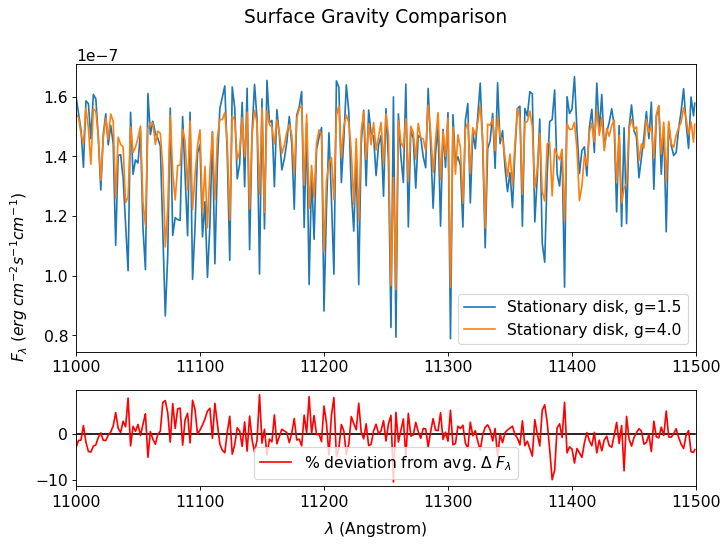

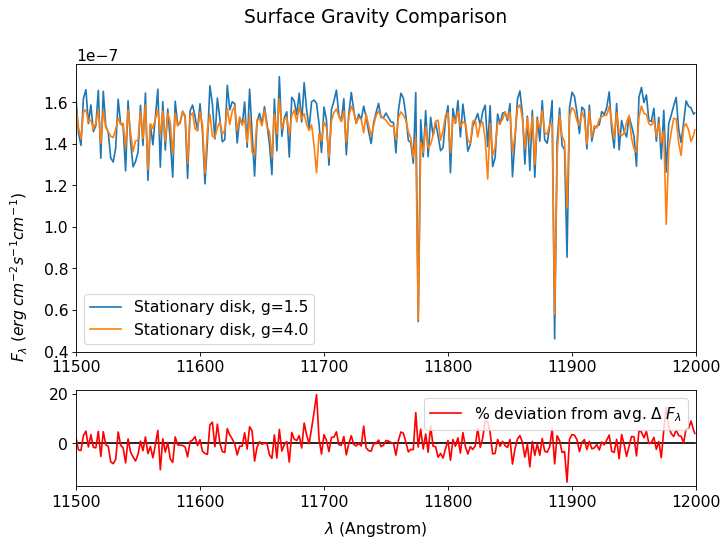

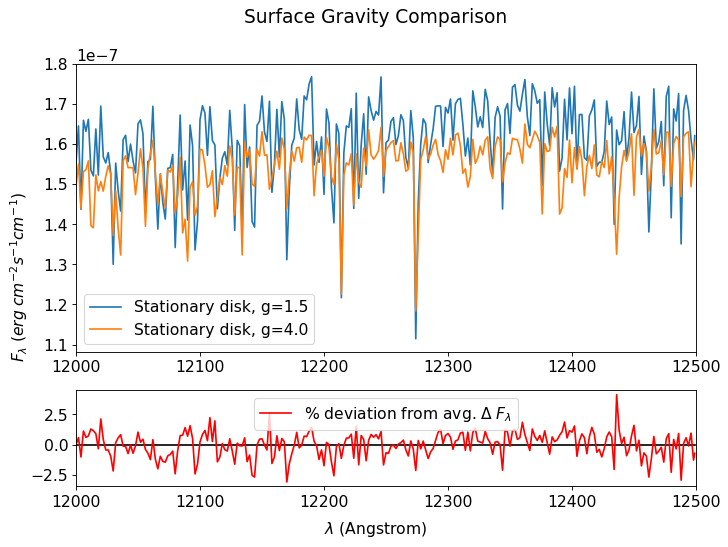

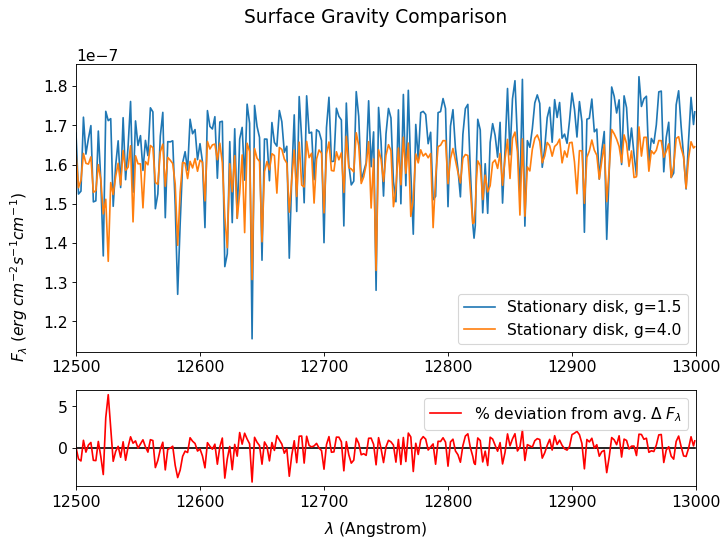

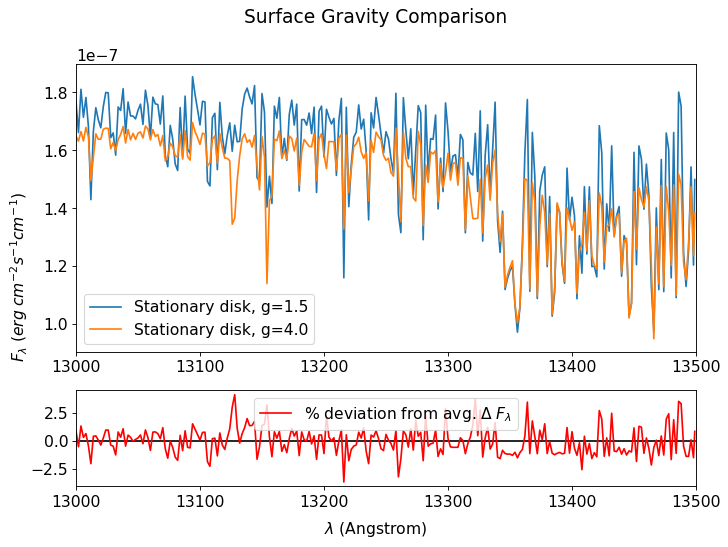

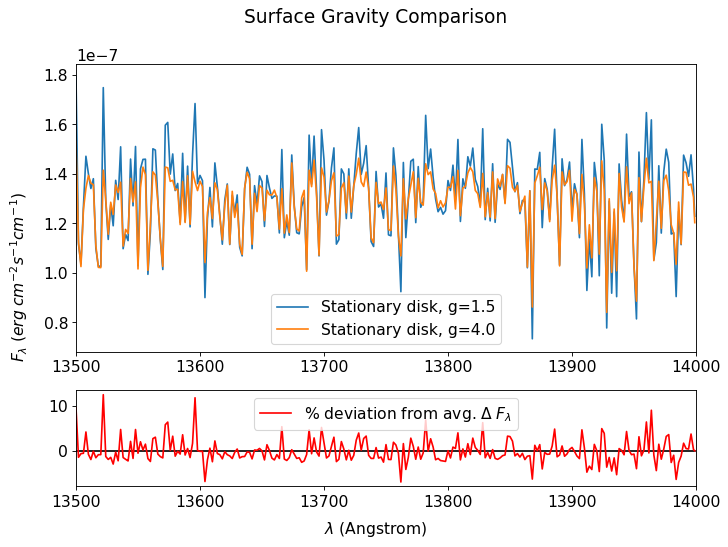

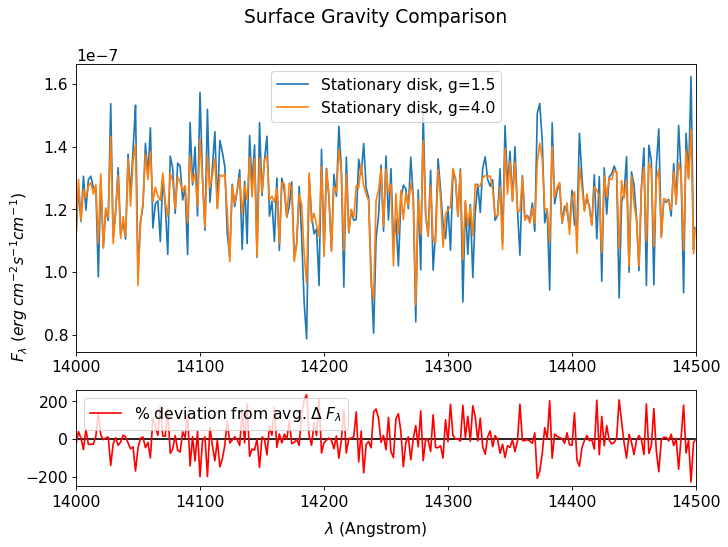

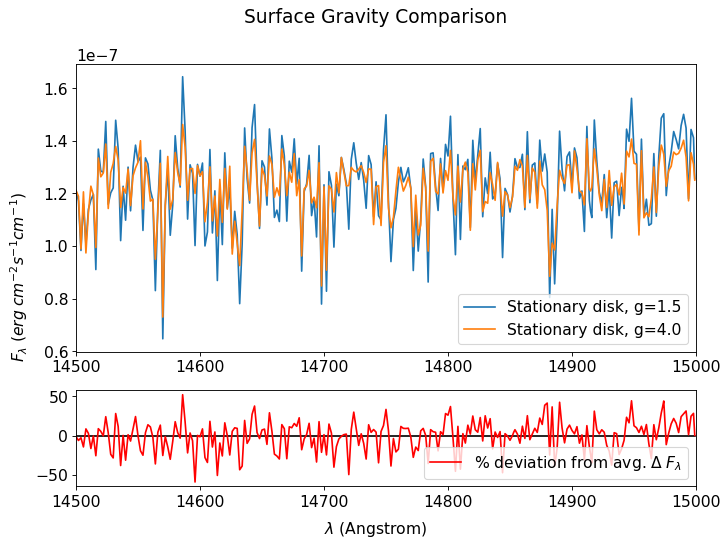

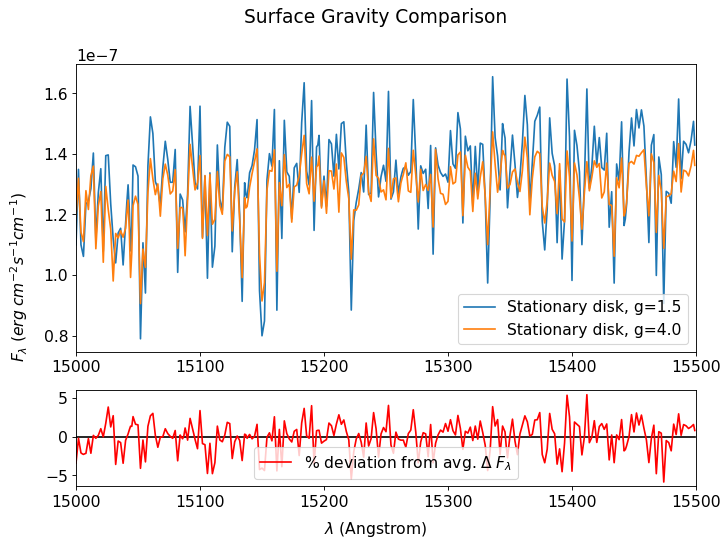

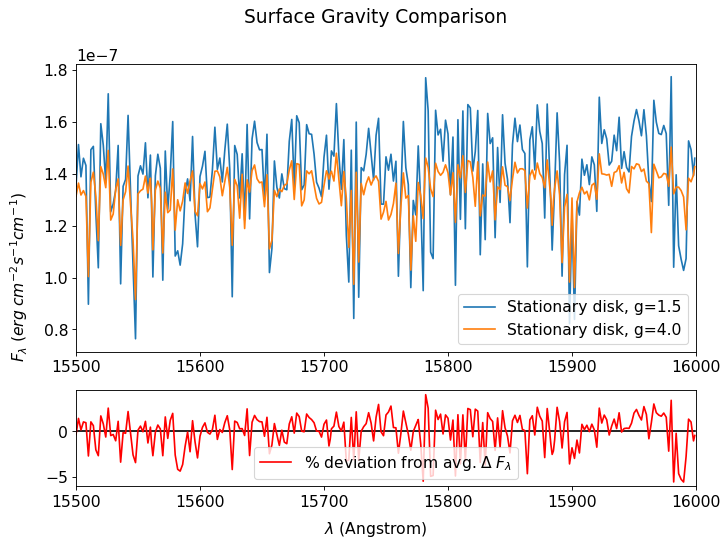

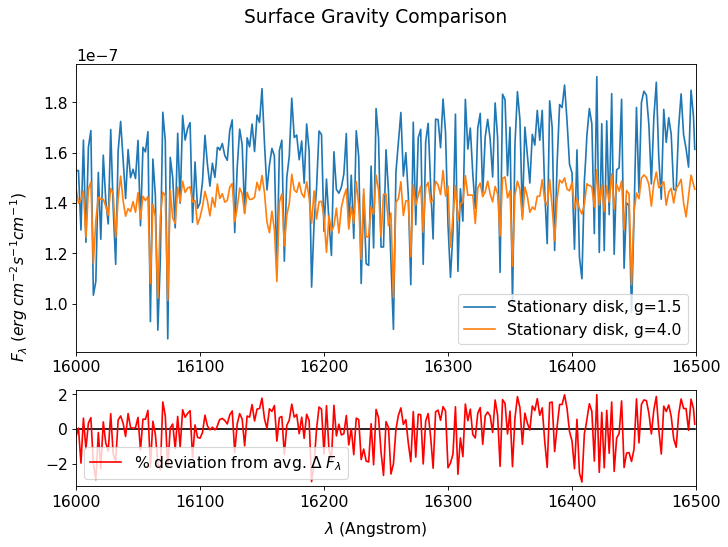

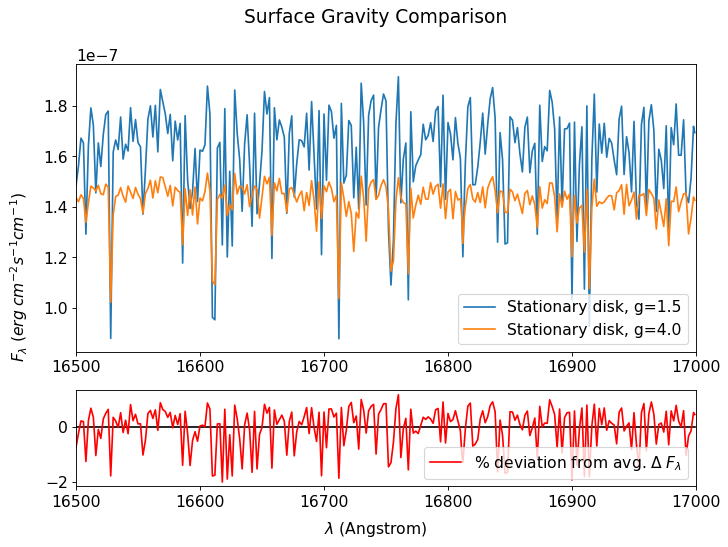

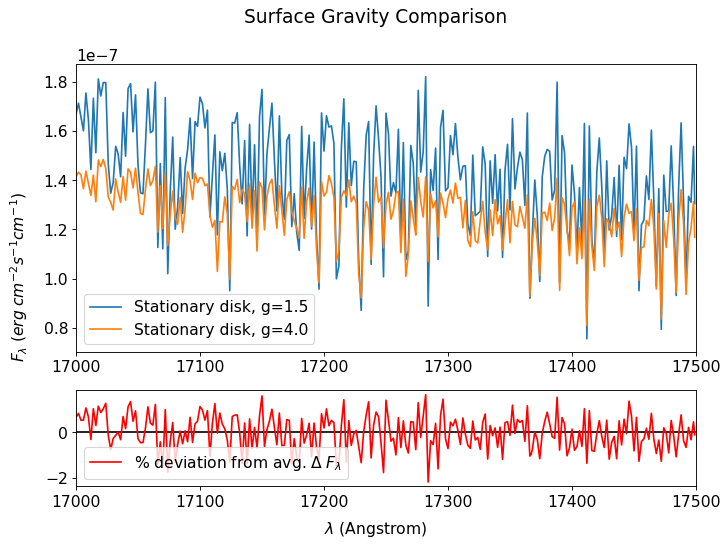

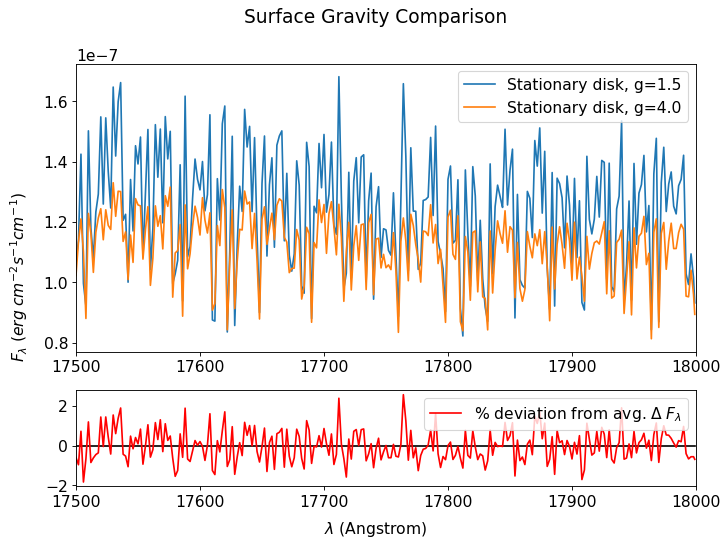

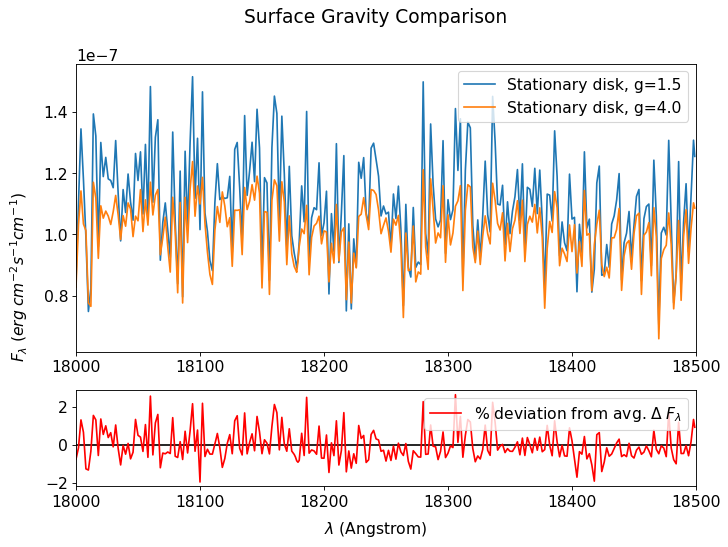

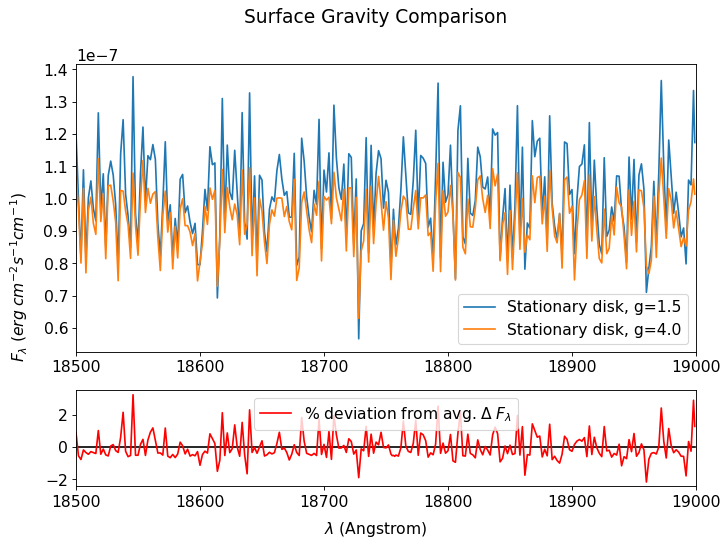

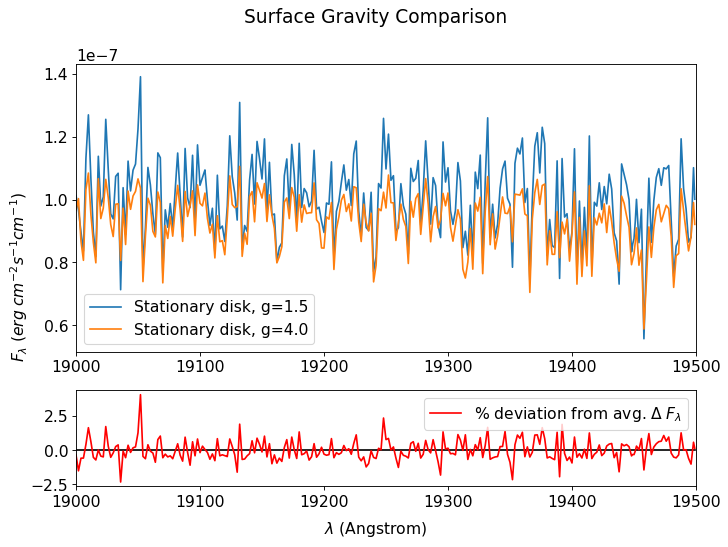

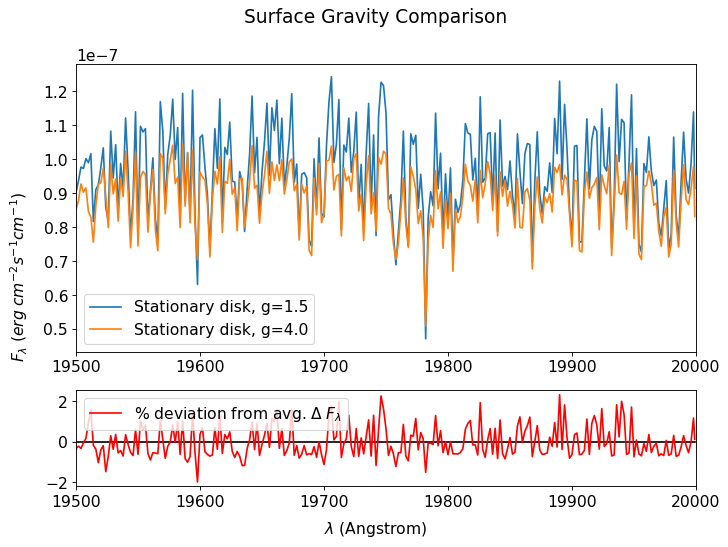

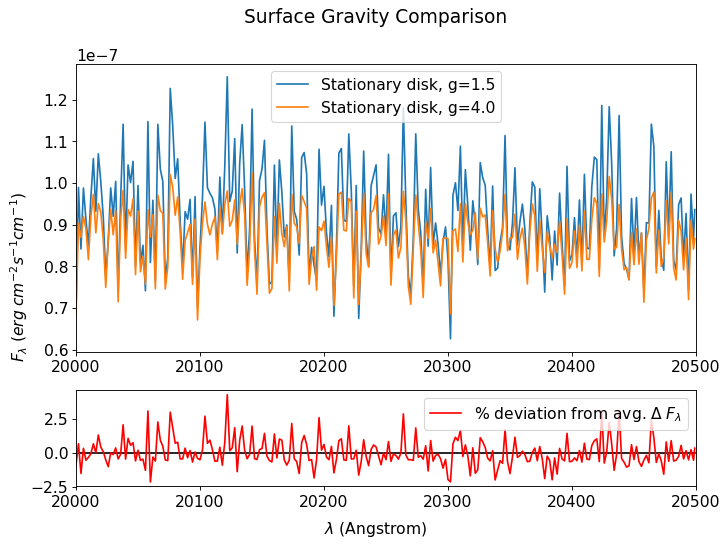

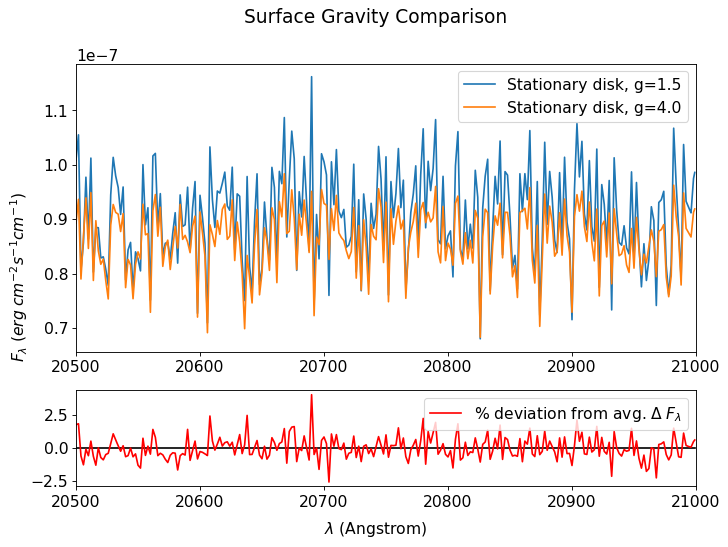

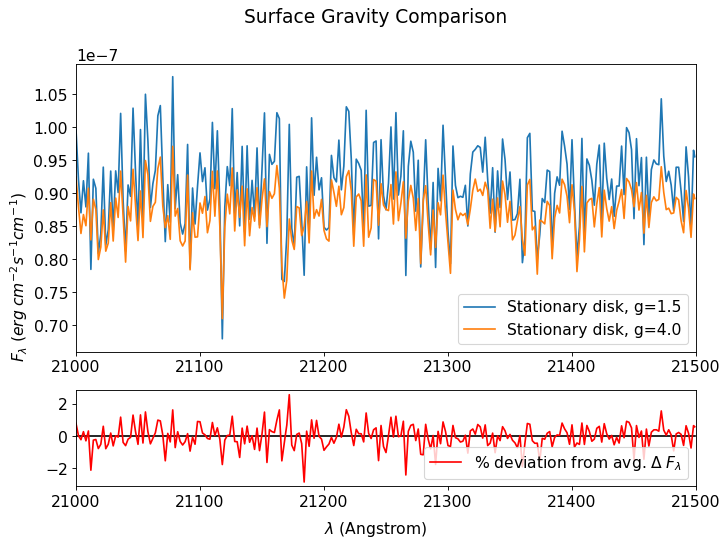

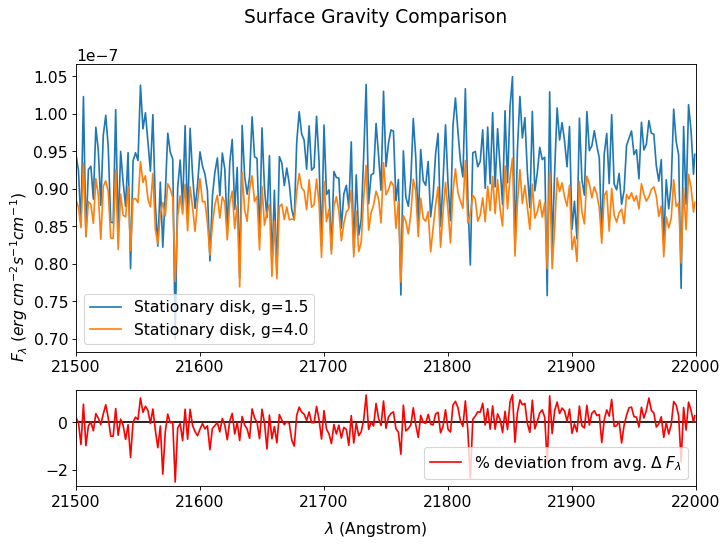

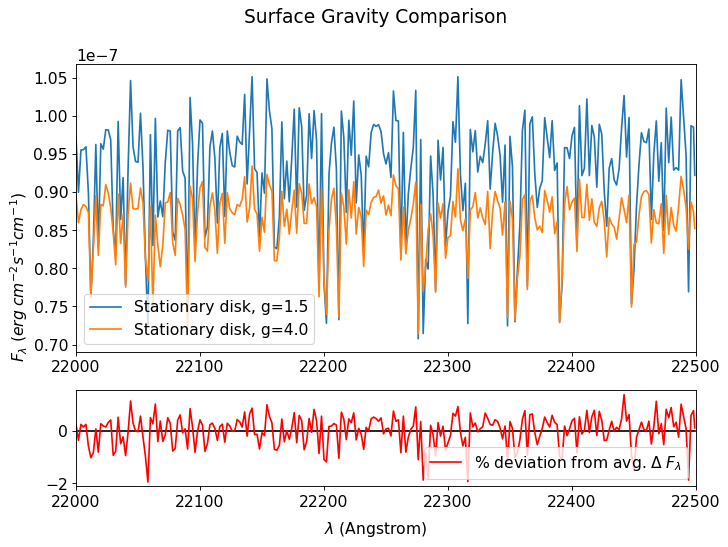

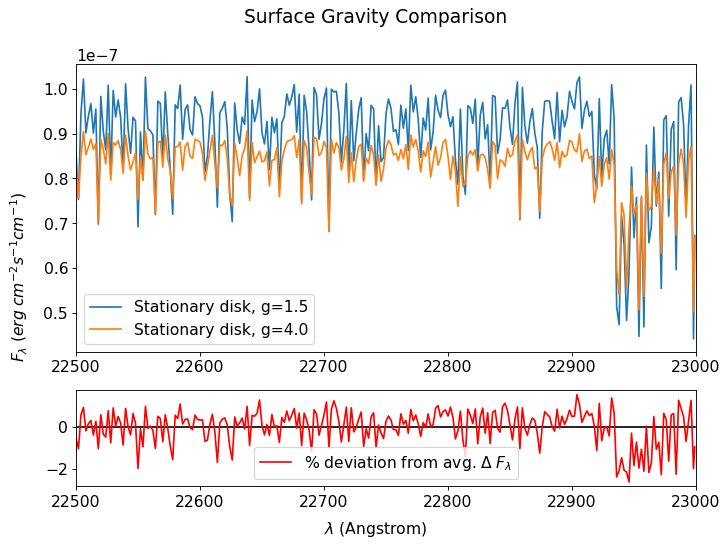

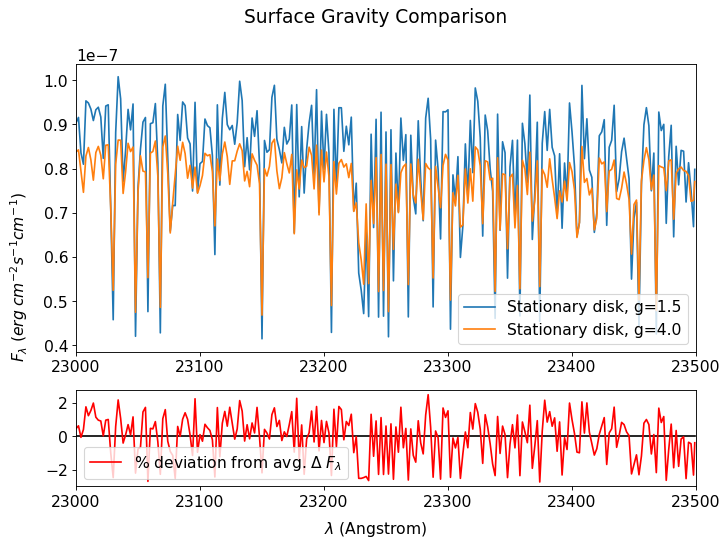

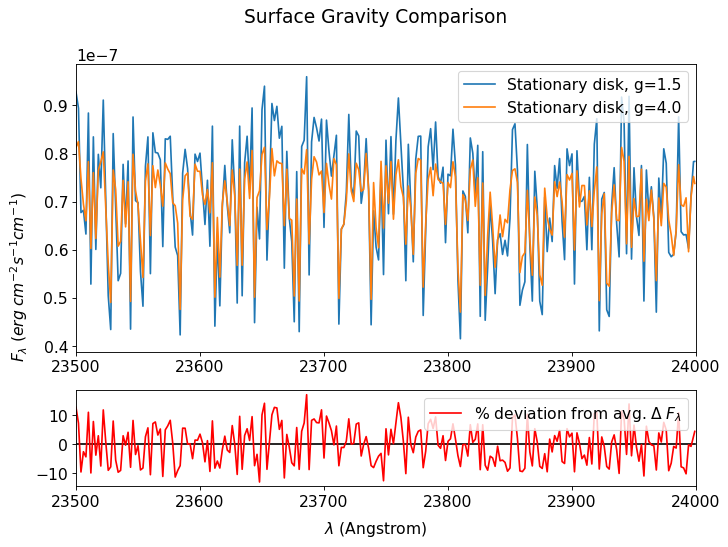

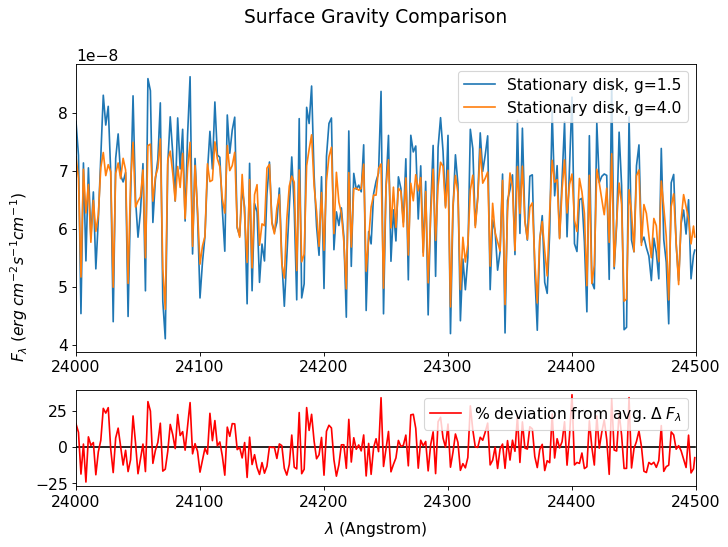

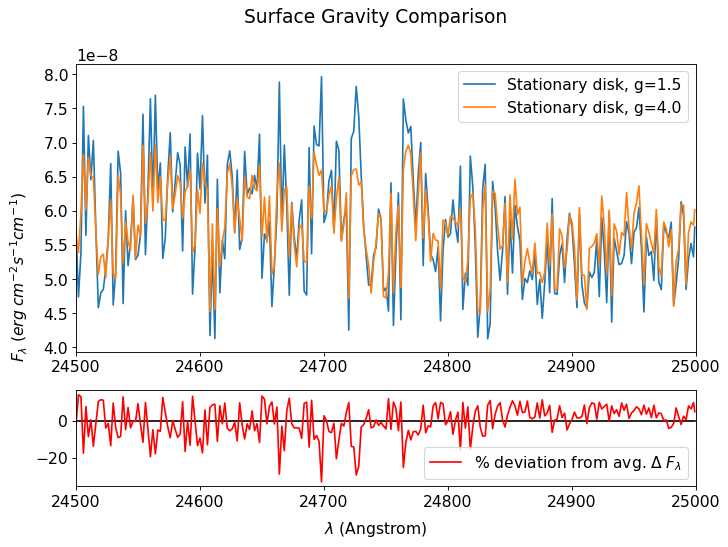

In [55]:
for i,j in waves_print:
    START = i
    END = j
    wav, lum = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 0, False, True)
    wav2, lum2 = gaia17bpi_env.viewModelSpectrum(START, END, 'fu ori', 1, False, True)
    
    wav0 = wav
    lum0 = (lum - lum2)
    diff_avg = np.mean(lum0)
    lum_percent = (lum0 - diff_avg)/diff_avg
    fig=plt.figure(figsize=(10, 7), dpi= 80)
    gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1])

    ax = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])

    ax.plot(wav, lum*np.cos(np.radians(10))/(2*np.pi*DIST**2), label='Stationary disk, g=1.5')
    ax.plot(wav2, lum2*np.cos(np.radians(10))/(2*np.pi*DIST**2), label='Stationary disk, g=4.0')
    # ax.plot(waves_DAT, fluxes_DAT*1e8, 'r--', label='Infrared spectrum')

    ax.legend()
    ax2.plot(wav0, np.zeros(len(wav0)), 'k-')
    ax2.plot(wav0, lum_percent, 'r-', label=r'% deviation from avg. $\Delta\; F_\lambda$')


    ax2.legend()
    plt.suptitle('Surface Gravity Comparison')
    fig.text(0.5, 0.04, r'$\lambda$ (Angstrom)', ha='center')
    fig.text(0.04, 0.5, r'$F_\lambda\; (erg \;cm^{-2} s^{-1} cm^{-1})$', va='center', rotation='vertical')
    ax.set_xlim(START, END)
    ax2.set_xlim(START, END)
    plt.show()
    save_string = 'Surface Gravity Comparison/comparison_' + str(START) + '_' + str(END) + '.png'
    fig.savefig(save_string, dpi=140)